In [15]:
# from jax import config
# config.update("jax_enable_x64", True)

In [2]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from matplotlib.path import Path
from matplotlib.patches import PathPatch

np.set_printoptions(precision=3, linewidth=500, threshold=500, suppress=True, edgeitems=5)


pd.set_option('display.max_rows', 60)
pd.set_option('display.min_rows', 30)
pd.set_option('display.width', 200)
pd.set_option('display.max_columns', 40)

%load_ext autoreload
%autoreload 2

%matplotlib ipympl

In [3]:
import networkx as nx
import subprocess
import matplotlib as mpl
from fredapi import Fred
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split
from typing import Literal, Union

In [4]:
from ndgsp import ProductGraph, Graph, KGR, GSR
from ndgsp import KGR, MultivariateFilterFunction
import os

Using Jax backend with device gpu:0


In [4]:
def create_features():

    base ='../data/green_bonds/Raw'

    regions = os.listdir(base)

    dfs = []

    for region in regions:

        for dt in ['Issuedate=2000 to 2015', 'Issue date= 2015 to 2021']:

            for activity in ['Active', 'Matured']:

                f1 = os.path.join(base, region, dt, activity, f'{region}- A2.xlsx')
                f2 = os.path.join(base, region, dt, activity, f'{region}- A3.xlsx')

                df1 = pd.read_excel(f1)[['ID_CUSIP', 'MUNI_TAX_PROV', 'ISSUE_DT', 'MATURITY', 'ISSUER_BULK', 'BB_COMPOSITE', 'MUNI_LONG_INDUSTRY_TYP']]
                df2 = pd.read_excel(f2)[['MUNI_PURPOSE']]

                df = pd.concat([df1, df2], axis=1)

                dfs.append(df)

    df = pd.concat(dfs, axis=0)

    return df

In [5]:
def get_features_and_yields():

    features = pd.read_csv('../data/green_bonds/Clean/Features.csv', index_col=0, parse_dates=[1, 2])
    features['MATURITY'] = pd.to_datetime(features['MATURITY'])

    # calculate maturity length
    features['MATURITY'] = (features['MATURITY'] - features['ISSUE_DT']).dt.days / 365
    features = features.drop(['ISSUE_DT'], axis=1)

    # remove problematic rows
    features = features[features['MATURITY'] < 50]
    features = features.dropna(subset='BB_COMPOSITE')
    features = features[features['BB_COMPOSITE'].isin(['AAA', 'AA+', 'AA', 'AA-', 'A+', 'A', 'A-', 'BBB+'])]

    # calculate continuous compounding rate
    # features['CPN_CONT'] = 100 * features['CPN_FREQ'] * np.log(1 + 0.01 * features['CPN'] / features['CPN_FREQ'])

    # remove unnecessary cols
    features = features.drop(['ISSUER_BULK'], axis=1).dropna()

    features = features[features['MUNI_TAX_PROV'].isin(['FED & ST TAX-EXEMPT',
                                        'FED TAXABLE/ST TAX-EXEMPT',
                                        'FED TAX-EXEMPT/ST TAXABLE',
                                        'FED BQ/ST TAX-EXEMPT',
                                        'FED TAX-EXEMPT',
                                        'AMT/ST TAX-EXEMPT',
                                        'FED TAXABLE/ST TAXABLE'])]
    
    yields = pd.read_csv('../data/green_bonds/Clean/Yields.csv', index_col=0, parse_dates=True).iloc[-1200:].resample('w').mean()

    bonds = sorted(set(yields.columns).intersection(set(features.index)))

    return features.loc[bonds], yields[bonds]

In [6]:
features, yields = get_features_and_yields()

In [7]:
def get_tax_graph():

    tax_nodes = ['Fed & St Tax-Exempt', 
                 'Fed Taxable/St Tax-Exempt', 
                 'Fed Tax-Exempt/St Taxable', 
                 'Fed BQ/St Tax-Exempt', 
                 'Fed Tax-Exempt', 
                 'AMT/St Tax-Exempt', 
                 'Fed Taxable/St Taxable']
    
    graph = nx.Graph()

    graph.add_nodes_from(tax_nodes)

    graph.add_edge('Fed & St Tax-Exempt', 'Fed Taxable/St Tax-Exempt')
    graph.add_edge('Fed & St Tax-Exempt', 'Fed Tax-Exempt/St Taxable')
    graph.add_edge('Fed & St Tax-Exempt', 'Fed BQ/St Tax-Exempt')
    graph.add_edge('Fed & St Tax-Exempt', 'Fed Tax-Exempt')
    graph.add_edge('Fed & St Tax-Exempt', 'AMT/St Tax-Exempt')
    graph.add_edge('Fed Taxable/St Tax-Exempt', 'Fed Taxable/St Taxable')
    graph.add_edge('Fed Tax-Exempt/St Taxable', 'Fed Taxable/St Taxable')
    graph.add_edge('Fed Tax-Exempt', 'Fed Tax-Exempt/St Taxable')
    graph.add_edge('Fed Taxable/St Tax-Exempt', 'AMT/St Tax-Exempt')
    graph.add_edge('Fed Taxable/St Tax-Exempt', 'Fed BQ/St Tax-Exempt')
    graph.add_edge('AMT/St Tax-Exempt', 'Fed BQ/St Tax-Exempt')

    return graph


In [8]:
tax_graph = get_tax_graph()

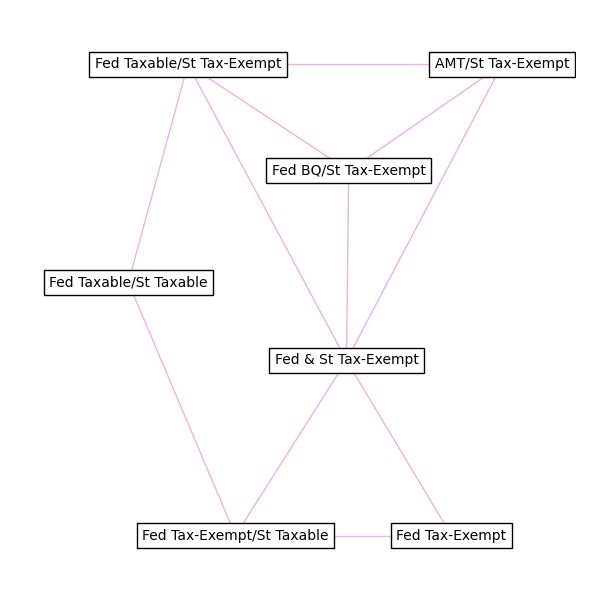

In [9]:
def plot_tax_graph(tax_graph, save=False):
    
    fig, ax = plt.subplots(figsize=(6, 6))

    pos = {'Fed & St Tax-Exempt': np.array([ 0.253, -0.08 ]),
    'Fed Taxable/St Tax-Exempt': np.array([-0.61 ,  0.652]),
    'Fed Tax-Exempt/St Taxable': np.array([-0.351, -0.513]),
    'Fed BQ/St Tax-Exempt': np.array([0.265, 0.389]),
    'Fed Tax-Exempt': np.array([ 0.824, -0.513  ]),
    'AMT/St Tax-Exempt': np.array([1.1, 0.652]),
    'Fed Taxable/St Taxable': np.array([-0.934, 0.113])}

    nx.draw_networkx_edges(tax_graph, pos, alpha=0.3, width=1, edge_color="m", ax=ax)
    nx.draw_networkx_nodes(tax_graph, pos, node_size=10, node_color="#210070", alpha=0.9, ax=ax)
    label_options = {"ec": "k", "fc": "white", "alpha": 1}
    nx.draw_networkx_labels(tax_graph, pos, font_size=10, bbox=label_options, ax=ax)

    ax.axis('off')

    ax.set_xlim(-1.5, 1.5)

    ax.set_aspect(2.2)

    plt.tight_layout()

    if save:

        plt.savefig('tax_graph.pdf')

        subprocess.run(['pdfcrop', 'tax_graph.pdf', 'tax_graph.pdf'])


plot_tax_graph(tax_graph)


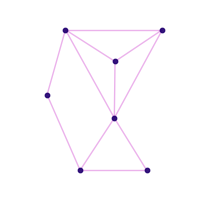

In [10]:
def plot_tax_graph_small(tax_graph, save=False):
    
    fig, ax = plt.subplots(figsize=(2, 2))

    pos = {'Fed & St Tax-Exempt': np.array([ 0.253, -0.08 ]),
    'Fed Taxable/St Tax-Exempt': np.array([-0.61 ,  0.652]),
    'Fed Tax-Exempt/St Taxable': np.array([-0.351, -0.513]),
    'Fed BQ/St Tax-Exempt': np.array([0.265, 0.389]),
    'Fed Tax-Exempt': np.array([ 0.824, -0.513  ]),
    'AMT/St Tax-Exempt': np.array([1.1, 0.652]),
    'Fed Taxable/St Taxable': np.array([-0.934, 0.113])}

    nx.draw_networkx_edges(tax_graph, pos, alpha=0.3, width=1, edge_color="m", ax=ax)
    nx.draw_networkx_nodes(tax_graph, pos, node_size=10, node_color="#210070", alpha=0.9, ax=ax)
    label_options = {"ec": "k", "fc": "white", "alpha": 1}
    # nx.draw_networkx_labels(tax_graph, pos, font_size=10, bbox=label_options, ax=ax)

    ax.axis('off')

    ax.set_xlim(-1.5, 1.5)

    plt.tight_layout()

    if save:

        plt.savefig('tax_graph_small.pdf')

        subprocess.run(['pdfcrop', 'tax_graph_small.pdf', 'tax_graph_small.pdf'])


plot_tax_graph_small(tax_graph)


In [9]:
def get_sector_graph(features):

    G = nx.Graph()

    G.add_node('Root')

    for node in sorted(features['MUNI_LONG_INDUSTRY_TYP'].unique()):

        G.add_node(node)
        G.add_edge('Root', node)

    for node, leaf in sorted(set([tuple(i) for i in features[['MUNI_LONG_INDUSTRY_TYP', 'MUNI_PURPOSE']].values])):

        G.add_edge(node, node + ': ' + leaf.title())

    return G

sector_graph = get_sector_graph(features)



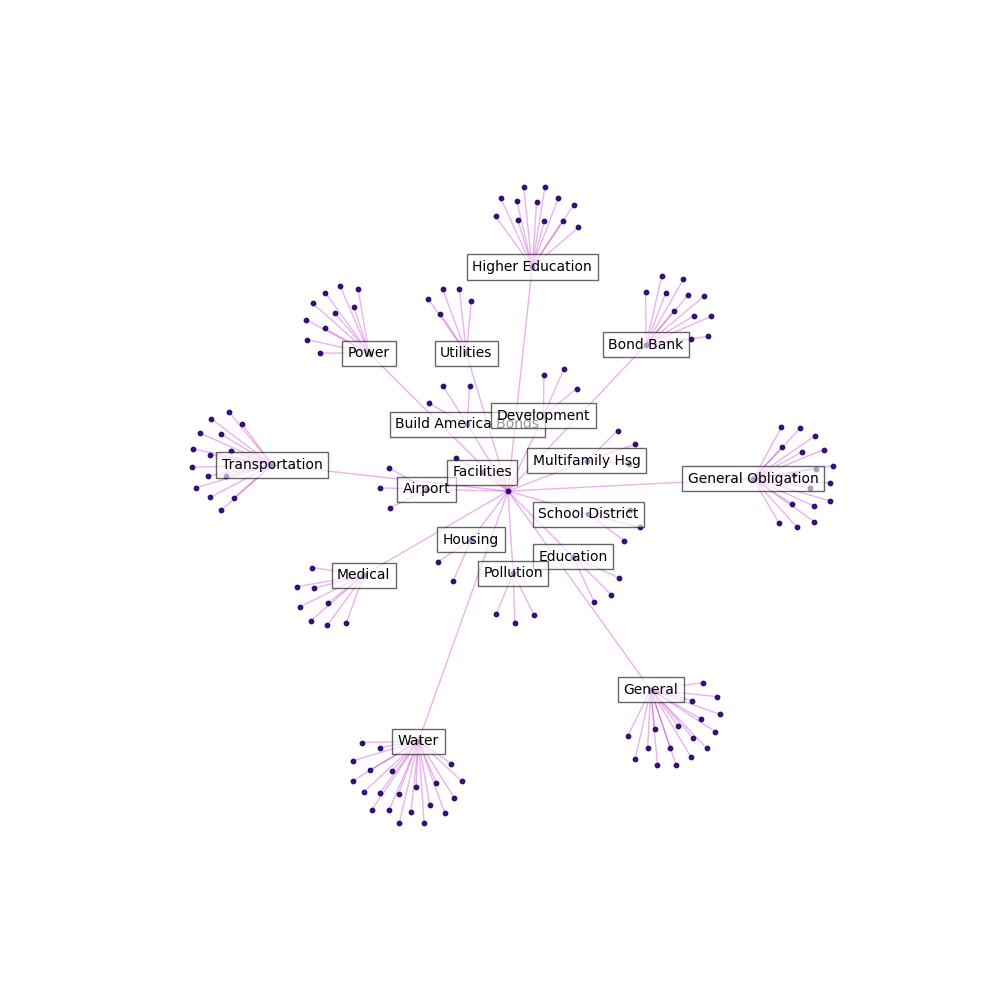

In [12]:
def plot_sector_graph(sector_graph, save=False):

    seed = 37
    fig, ax = plt.subplots(figsize=(10, 10))
    pos = nx.spring_layout(sector_graph, seed=seed)

    nx.draw_networkx_edges(sector_graph, pos, alpha=0.3, width=1, edge_color="m", ax=ax)
    nx.draw_networkx_nodes(sector_graph, pos, node_size=10, node_color="#210070", alpha=0.9, ax=ax)
    label_options = {"ec": "k", "fc": "white", "alpha": 0.6}
    nx.draw_networkx_labels(sector_graph, pos, font_size=10, bbox=label_options, ax=ax, labels={n:n for n in features['MUNI_LONG_INDUSTRY_TYP'].unique()})

    ax.axis('off')

    if save:

        plt.savefig('bond_graph.pdf')

        subprocess.run(['pdfcrop', 'bond_graph.pdf', 'bond_graph.pdf'])

plot_sector_graph(sector_graph)

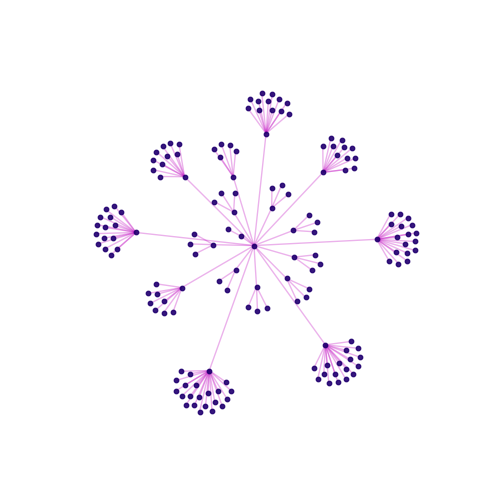

In [13]:
def plot_sector_graph_small(sector_graph, save=False):

    seed = 37
    fig, ax = plt.subplots(figsize=(5, 5))
    pos = nx.spring_layout(sector_graph, seed=seed)

    nx.draw_networkx_edges(sector_graph, pos, alpha=0.3, width=1, edge_color="m", ax=ax)
    nx.draw_networkx_nodes(sector_graph, pos, node_size=10, node_color="#210070", alpha=0.9, ax=ax)
    label_options = {"ec": "k", "fc": "white", "alpha": 0.6}

    ax.axis('off')

    if save:

        plt.savefig('bond_graph_small.pdf')

        subprocess.run(['pdfcrop', 'bond_graph_small.pdf', 'bond_graph_small.pdf'])

plot_sector_graph_small(sector_graph)

In [10]:


def get_Y(features, yields, sector_graph, tax_graph):

    sectors = list(sector_graph.nodes())
    taxes = list(tax_graph.nodes())

    def get_sector_node(row):
        return sectors.index(f"{row['MUNI_LONG_INDUSTRY_TYP']}: {row['MUNI_PURPOSE'].title()}")
        
    def get_tax_nodes(item):  
        return taxes.index(f"{item.title().replace('Bq', 'BQ').replace('Amt', 'AMT')}")

    features['Sector'] = features[['MUNI_LONG_INDUSTRY_TYP', 'MUNI_PURPOSE']].apply(get_sector_node, axis=1)
    features['Rating'] = features['BB_COMPOSITE'].replace({'AAA': 0, 'AA+': 1, 'AA': 2, 'AA-': 3, 'A+': 4, 'A': 5, 'A-': 6, 'BBB+': 7})
    features['Maturity'] = np.digitize(features['MATURITY'].values, bins =[0, 1, 2, 5, 10, 20, 30, 40, 50]) - 1
    features['Tax'] = features['MUNI_TAX_PROV'].apply(get_tax_nodes)

    # features['Coupon'] = np.digitize(features['CPN'].values, bins=[0, 1, 2, 3, 4, 5, 100]) - 1

    T = len(yields)
    N = len(sectors)
    N_ratings = len(features['Rating'].unique())
    # N_coupons = len(features['Coupon'].unique())
    N_maturities = len(features['Maturity'].unique())
    N_tax = len(features['Tax'].unique())

    Y = np.zeros((T, N, N_maturities, N_ratings, N_tax))

    Y[:] = np.nan

    
    for (n, n_m, n_r, n_t), df in features.groupby(['Sector', 'Maturity', 'Rating', 'Tax']):

        bonds = df.index.tolist()

        bond = max(bonds, key=lambda bond: len(yields[bond].dropna()))

        Y[:, n, n_m, n_r, n_t] = yields[bond].values

    return Y


def get_product_graph(Y, sector_graph, tax_graph, model=Union[Literal['GSR'], Literal['KGR']]):

    T, N_sectors, N_maturities, N_ratings, N_taxes = Y.shape

    if model == 'KGR':
        graph = ProductGraph(graphs=[Graph.from_networkx(sector_graph), 
                                     Graph.chain(N_maturities), 
                                     Graph.chain(N_ratings), 
                                     Graph.from_networkx(tax_graph)])
    if model == 'GSR':
        graph = ProductGraph(graphs=[Graph.chain(T), 
                                     Graph.from_networkx(sector_graph), 
                                     Graph.chain(N_maturities), 
                                     Graph.chain(N_ratings), 
                                     Graph.from_networkx(tax_graph)])
        
    return graph


Y = get_Y(features, yields, sector_graph, tax_graph)

graph_kgr = get_product_graph(Y, sector_graph, tax_graph, model='KGR')
graph_gsr = get_product_graph(Y, sector_graph, tax_graph, model='GSR')

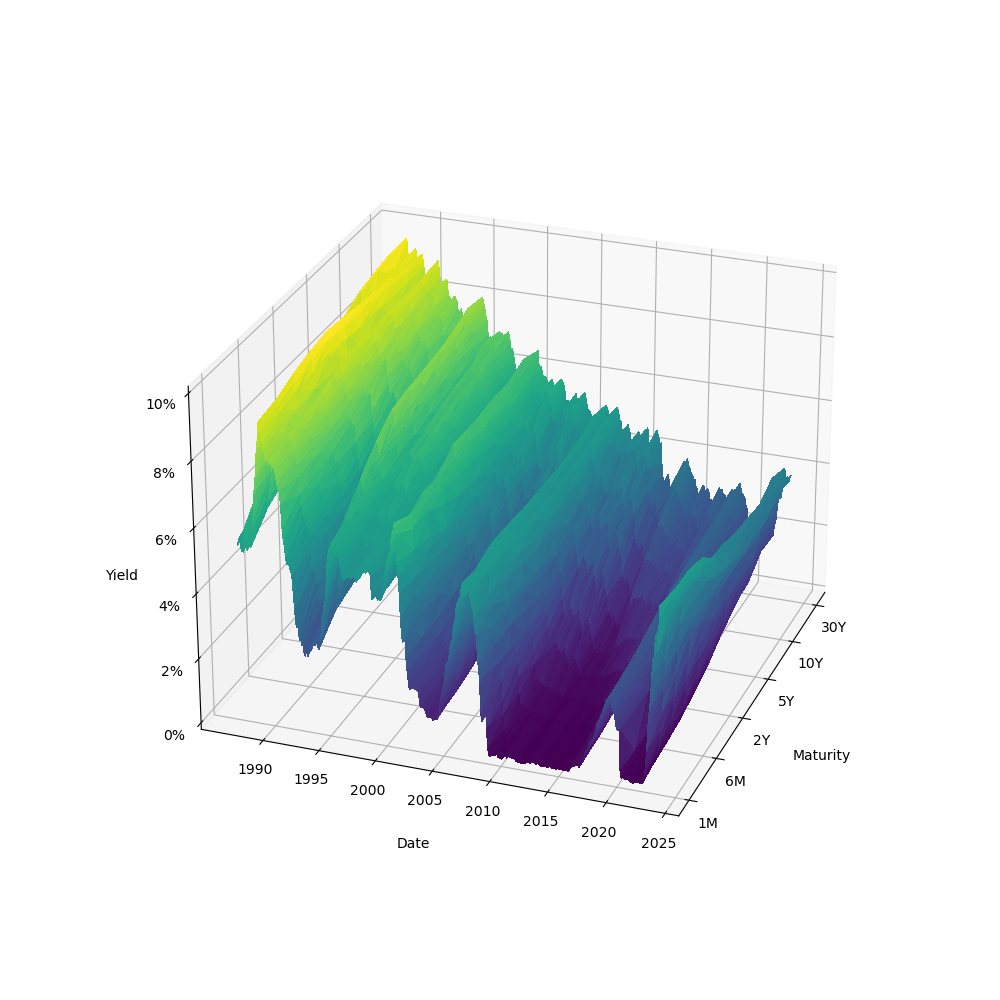

In [15]:
def get_fed_data(from_file=True):
        
    if from_file:
        data = pd.read_csv('../data/green_bonds/T-Bills.csv', index_col=0, parse_dates=True)

    else:

        with open('api_key.txt') as f:
            api_key = f.read()
    
        fred = Fred(api_key=api_key)

        data = []

        for ticker in ["DGS30", "DGS20", "DGS10", "DGS7", "DGS5", "DGS3", "DGS2", "DGS1", "DGS6MO", "DGS3MO", "DGS1MO"]:
            data.append(fred.get_series(ticker))

        data = pd.concat(data, axis=1)

        data.columns = ["30Y", "20Y", "10Y", "7Y", "5Y", "3Y", "2Y", "1Y", "6M", "3M", "1M"]
    
    return data


def interpolate(data, order=2):
    """
    Fill in the nans in each column by running a polynomial regression of order=order
    """
    
    x = np.arange(len(data.columns))
    
    coeffs = []
    
    for xs in set(tuple(i) for i in (~data.isnull()).values.tolist()):
    
        X = np.array([x[list(xs)] ** i for i in range(order + 1)]).T

        coeffs.append((np.linalg.inv(X.T @ X) @ X.T @ data[np.all(~data.isnull() == xs, axis=1).values].dropna(axis=1).T).T)

    coeffs = pd.concat(coeffs).sort_index()
    
    data_interp = data.copy()

    data_interp[:] = sum(coeffs[i].values[:, None] * x ** i for i in range(order + 1))
    
    data_filled = data.copy()
    
    data_filled.values[data.isnull()] = data_interp.values[data.isnull()]
    
    return data_filled


def plot_3d_fed_rate(data_M_interp, save=False):
    
    time = (data_M_interp.iloc[300:].index.year + (data_M_interp.iloc[300:].index.day_of_year / (365 + data_M_interp.iloc[300:].index.is_leap_year.astype(int)))).values
    x, y = np.meshgrid(np.arange(len(data.columns)), time)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(projection='3d')

    for i in range(2):
        surf=ax.plot_trisurf(x.ravel(), y.ravel(), data_M_interp.iloc[300:].values.ravel(), cmap=mpl.cm.viridis, lw=None, antialiased=False, shade=False, edgecolor=(0,0,0,0))

    ax.view_init(25.79, 19.98)
    ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: data_M_interp.columns[min(int(x), 10)])) 

    ax.zaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: f'{x:.0f}%')) 

    ax.xaxis.set_rotate_label(False)
    ax.yaxis.set_rotate_label(False)
    ax.zaxis.set_rotate_label(False)

    ax.set_ylabel('Date', labelpad=15)
    ax.set_xlabel('Maturity', labelpad=20)
    ax.set_zlabel('Yield', labelpad=10)

    ax.yaxis.label.set_rotation(0)
    ax.zaxis.label.set_rotation(0)

    ax.set_zlim(0, 10)

    if save:

        plt.savefig('fed_rates.pdf')

        subprocess.run(['pdfcrop', 'fed_rates.pdf', 'fed_rates.pdf'])


data = get_fed_data(from_file=True)
data_M = data.resample('M').mean()
data_M_interp = interpolate(data_M)
plot_3d_fed_rate(data_M_interp)

In [11]:
def get_X():

    df1 = pd.read_csv('../data/green_bonds/T-Bills.csv', index_col=0, parse_dates=True).resample('w').mean().loc['2018-06-10':'2023-03-12']
    df2 = pd.read_csv('../data/green_bonds/FedRates.csv', index_col=0, parse_dates=True).resample('w').mean().loc['2018-06-10':'2023-03-12']
    df3 = pd.read_csv('../data/green_bonds/Inflation.csv', index_col=0, parse_dates=True).resample('w').mean().loc['2018-06-10':'2023-03-12'].ffill().bfill()

    X = pd.concat([df1, df2, df3], axis=1)

    X = np.concatenate([np.linspace(-1, 1, len(X))[:, None], X], axis=1)

    return X


X = get_X()

In [12]:


def get_Y_train_val_test_uniform(Y, train=0.8, val=0.1, test=0.1, seed=0):
    """
    Get train, val, test data by removing elements uniformly
    """
    
    rng = np.random.default_rng(seed)

    assert (train + val + test) == 1

    inds_all = np.argwhere(~np.isnan(Y))

    rng.shuffle(inds_all)

    inds_train = inds_all[:int(train * len(inds_all))]
    inds_val = inds_all[int(train * len(inds_all)):int((train + val) * len(inds_all))]
    inds_test = inds_all[int((train + val) * len(inds_all)):]

    Y_train = Y.copy()
    Y_train[inds_val[:, 0], inds_val[:, 1], inds_val[:, 2], inds_val[:, 3], inds_val[:, 4]] = np.nan
    Y_train[inds_test[:, 0], inds_test[:, 1], inds_test[:, 2], inds_test[:, 3], inds_test[:, 4]] = np.nan

    
    return Y_train, inds_val, inds_test, inds_train


def get_Y_train_val_test_bondwise(Y, train=0.8, val=0.1, test=0.1, seed=0):
    """
    Get train, val, test data by removing bonds randomly
    """

    assert (train + val + test) == 1

    inds_all = np.argwhere((~np.isnan(Y)).sum(0).astype(bool))
    
    inds_train, inds_valtest = train_test_split(inds_all, train_size=train, test_size=val+test, random_state=seed)
    inds_val, inds_test = train_test_split(inds_valtest, train_size=val/(val+test), test_size=test/(val+test), random_state=seed)

    Y_train = Y.copy()
    Y_train[:, inds_val[:, 0], inds_val[:, 1], inds_val[:, 2], inds_val[:, 3]] = np.nan
    Y_train[:, inds_test[:, 0], inds_test[:, 1], inds_test[:, 2], inds_val[:, 3]] = np.nan

    def upscale(inds):

        inds_all = None

        for row in inds:

            ts = np.argwhere(~np.isnan(Y[:, row[0], row[1], row[2], row[3]]))

            if inds_all is None:
                inds_all = np.concatenate([ts, np.repeat([row], ts.shape[0], axis=0)], axis=1)
            else:
                inds_all = np.concatenate([inds_all, np.concatenate([ts, np.repeat([row], ts.shape[0], axis=0)], axis=1)], axis=0)

        return inds_all

    inds_val = upscale(inds_val)
    inds_test = upscale(inds_test)
    inds_train = upscale(inds_train)
    
    return Y_train, inds_val, inds_test, inds_train


def mse(Y_pred, inds):
    Y_pred_ = Y_pred[inds[:, 0], inds[:, 1], inds[:, 2], inds[:, 3], inds[:, 4]]
    Y_ = Y[inds[:, 0], inds[:, 1], inds[:, 2], inds[:, 3], inds[:, 4]]
    return ((Y_pred_ - Y_) ** 2).sum() / len(inds)


def r_squared(Y_pred, inds):
    Y_pred_ = Y_pred[inds[:, 0], inds[:, 1], inds[:, 2], inds[:, 3], inds[:, 4]]
    Y_ = Y[inds[:, 0], inds[:, 1], inds[:, 2], inds[:, 3], inds[:, 4]]

    return 1 - ((Y_pred_ - Y_) ** 2).sum() / ((Y_.mean() - Y_) ** 2).sum() 


Y_train_bondwise, inds_val_bondwise, inds_test_bondwise, inds_train_bondwise = get_Y_train_val_test_bondwise(Y, seed=2)

In [13]:
best_params = {'GSR': {'gamma': 7.9699e-08, 'beta': [2.9692e+00, 4.6880e+03, 9.9854e-01, 1.0058e+00, 9.9968e-01]}, 
               'KGR': {'gamma': 2.9208e-06, 'kstd': 2.3803e+00, 'beta': [1.9417e+03, 9.9737e-01, 1.0082e+00, 9.9984e-01]}} 


def get_best_kgr_model(Y_train, inds_val):

    MAX_ITERS = 100
    its = 0

    fil_kgr = MultivariateFilterFunction.diffusion(best_params['KGR']['beta'])
    model_kgr = KGR(X, Y_train, graph_kgr, fil_kgr, best_params['KGR']['gamma'], best_params['KGR']['kstd'])  

    all_params = []
    errs = []

    def loss(params, inds):
        nonlocal its

        all_params.append(params)
        gamma, kstd, beta1, beta2, beta3, beta4 = np.exp(params)

        model_kgr.set_gamma(gamma)
        model_kgr.set_kernel_std(kstd)
        model_kgr.set_beta([beta1, beta2, beta3, beta4])

        pred = model_kgr.solve()
        err = mse(pred, inds)
        errs.append(err)
    
        its += 1
        print(f'Params: gamma={gamma:.4e}, kstd={kstd:.4e}, beta=[{beta1:.4e}, {beta2:.4e}, {beta3:.4e}, {beta4:.4e}]. MSE={err:.4e}. Iterations: {its}', end='\r')
        
        if its >= MAX_ITERS:
            raise KeyboardInterrupt
        
        return err
    

    try:

        params0 = [best_params['KGR']['gamma'], best_params['KGR']['kstd']] + best_params['KGR']['beta']
        out = minimize(loss, args=(inds_val, ), x0=np.log(params0), method='Nelder-Mead')

    except KeyboardInterrupt:
        pass

    print('\n')

    return model_kgr, np.array(all_params), np.array(errs)



def get_best_gsr_model(Y_train, inds_val):

    MAX_ITERS = 100
    its = 0

    fil_gsr = MultivariateFilterFunction.diffusion(best_params['GSR']['beta'])
    model = GSR(Y_train, graph_gsr, fil_gsr, best_params['GSR']['gamma'])

    all_params = []
    errs = []

    def loss(params, inds):
        nonlocal its

        all_params.append(params)
        gamma, beta1, beta2, beta3, beta4, beta5 = np.exp(params)
        model.set_gamma(gamma)
        model.set_beta([beta1, beta2, beta3, beta4, beta5])

        pred = model.solve()
        err = mse(pred, inds)
        errs.append(err)

        its += 1

        print(f'Params: gamma={gamma:.4e}, beta=[{beta1:.4e}, {beta2:.4e}, {beta3:.4e}, {beta4:.4e}, {beta5:.4e}]. MSE={err:.4e}. Iterations: {its}', end='\r')
        
        if its >= MAX_ITERS:
            raise KeyboardInterrupt
        
        return err
    
    try:
        
        params0 = [best_params['GSR']['gamma']] + best_params['GSR']['beta']
        out = minimize(loss, args=(inds_val, ), x0=np.log(params0), method='Nelder-Mead')

    except KeyboardInterrupt:
        pass

    print('\n')

    return model, np.array(all_params), np.array(errs)



In [18]:
model_gsr, params_gsr, err_gsr = get_best_gsr_model(Y_train_bondwise, inds_val_bondwise)

Params: gamma=7.9699e-08, beta=[2.9692e+00, 4.6880e+03, 9.9854e-01, 1.0058e+00, 9.9968e-01]. MSE=3.3315e-01



In [24]:
model_kgr, params_kgr, err_kgr = get_best_kgr_model(Y_train_bondwise, inds_val_bondwise)

Params: gamma=2.9208e-06, kstd=2.3803e+00, beta=[1.9417e+03, 9.9737e-01, 1.0082e+00, 9.9984e-01]. MSE=3.3324e-01. Iterations: 100



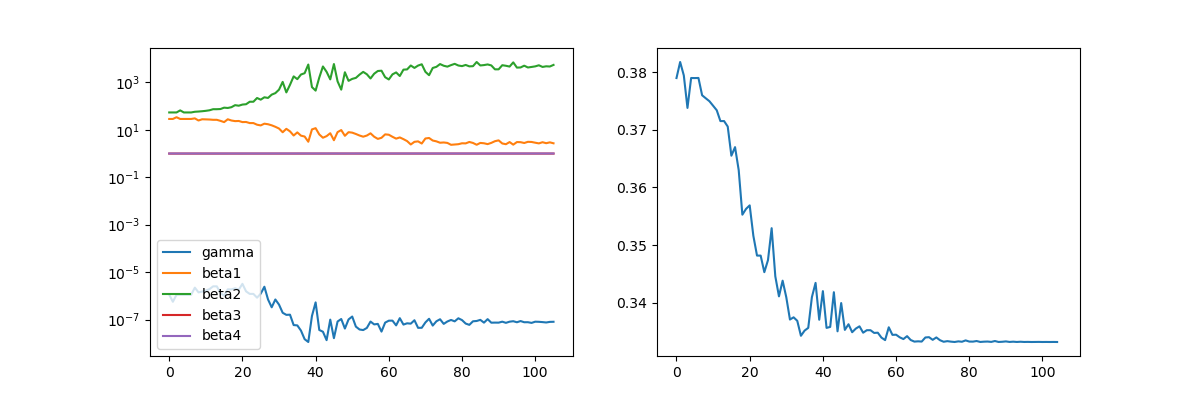

In [20]:
def plot_gsr_err(params, err):

    fig, axes = plt.subplots(ncols=2, figsize=(12, 4), sharex=True)

    for i, name in enumerate(['gamma', 'beta1', 'beta2', 'beta3', 'beta4', 'beta5']):

        axes[0].plot(np.exp(params[:, i]), label=name)

    axes[0].legend()
    axes[0].set_yscale('log')

    axes[1].plot(err)

plot_gsr_err(params_gsr, err_gsr)

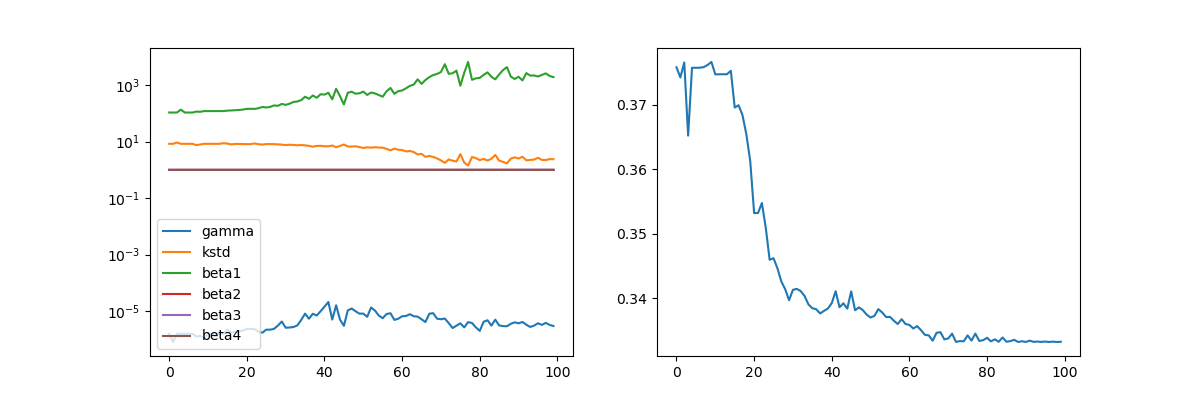

In [26]:
def plot_kgr_err(params, err):

    fig, axes = plt.subplots(ncols=2, figsize=(12, 4))

    for i, name in enumerate(['gamma', 'kstd', 'beta1', 'beta2', 'beta3', 'beta4']):

        axes[0].plot(np.exp(params[:, i]), label=name)

    axes[0].legend()
    axes[0].set_yscale('log')

    axes[1].plot(err)

plot_kgr_err(params_kgr, err_kgr)

In [38]:
fil_gsr = MultivariateFilterFunction.diffusion(best_params['GSR']['beta'])
model_gsr = GSR(Y_train_bondwise, graph_gsr, fil_gsr, best_params['GSR']['gamma'])


In [39]:
fil_kgr = MultivariateFilterFunction.diffusion(best_params['KGR']['beta'])
model_kgr = KGR(X, Y_train_bondwise, graph_kgr, fil_kgr, best_params['KGR']['gamma'], best_params['KGR']['kstd'])  

In [40]:
Y_kgr = model_kgr.solve()

mse_train = mse(Y_kgr, inds_train_bondwise)
mse_val = mse(Y_kgr, inds_val_bondwise)
mse_test = mse(Y_kgr, inds_test_bondwise)

rs_train = r_squared(Y_kgr, inds_train_bondwise)
rs_val = r_squared(Y_kgr, inds_val_bondwise)
rs_test = r_squared(Y_kgr, inds_test_bondwise)

print(f'KGR: train: MSE: {mse_train:.4f}, R^2: {rs_train:.4f}. val: MSE: {mse_val:.4f}, R^2: {rs_val:.4f}. test: MSE: {mse_test:.4f}, R^2: {rs_test:.4f}')

KGR: train: MSE: 0.2660, R^2: 0.8449. val: MSE: 0.3332, R^2: 0.8199. test: MSE: 0.3174, R^2: 0.8241


In [41]:
Y_gsr = model_gsr.solve()

mse_train = mse(Y_gsr, inds_train_bondwise)
mse_val = mse(Y_gsr, inds_val_bondwise)
mse_test = mse(Y_gsr, inds_test_bondwise)

rs_train = r_squared(Y_gsr, inds_train_bondwise)
rs_val = r_squared(Y_gsr, inds_val_bondwise)
rs_test = r_squared(Y_gsr, inds_test_bondwise)

print(f'GSR: train: MSE: {mse_train:.4f}, R^2: {rs_train:.4f}. val: MSE: {mse_val:.4f}, R^2: {rs_val:.4f}. test: MSE: {mse_test:.4f}, R^2: {rs_test:.4f}')

GSR: train: MSE: 0.2635, R^2: 0.8463. val: MSE: 0.3332, R^2: 0.8199. test: MSE: 0.3189, R^2: 0.8233


In [74]:
# T, sector_graph, N_maturities, N_ratings, tax_graph
# 256 x 159 x            8 x          8 x       7

Graph(N=159 x 8 x 8 x 7)

In [108]:
best_params['KGR']['kstd']

2.3803

In [109]:
model_kgr.set_gamma(1e-3)

model_kgr.set_beta([30, 0.3, 2.5, 1.0])

model_kgr.set_kernel_std(20)

samples_kgr = model_kgr.sample(n_samples=20)

std_kgr = np.std(samples_kgr, axis=0)

del samples_kgr

100%|██████████| 20/20 [00:29<00:00,  1.50s/it]


In [94]:
model_gsr.set_gamma(1e-2)

model_gsr.set_beta([5.0, 30, 0.1, 0.5, 0.5])

samples_gsr = model_gsr.sample(n_samples=20)

std_gsr = np.std(samples_gsr, axis=0)

del samples_gsr

100%|██████████| 20/20 [00:12<00:00,  1.65it/s]


0.758338466358402

In [137]:
def plot_predictions(Y_pred, pred_std, col, save=False, name=None):

    iidns = [[140, 1, 4, 1], 
            [23, 4, 2, 0], 
            [156, 2, 0, 2], 
            [121, 5, 7, 1], 
            [54, 2, 0, 0], 
            [46, 5, 2, 0], 
            [72, 4, 1, 2], 
            [127, 4, 7, 0], 
            [111, 3, 0, 1]]

    mats = ['0-1y', '1-2y', '2-5y', '5-10y', '10-20y', '20-30y', '30-40y', '40-50y']
    taxes = ['Fed & St Tax-Exempt', 
                 'Fed Taxable/St Tax-Exempt', 
                 'Fed Tax-Exempt/St Taxable', 
                 'Fed BQ/St Tax-Exempt', 
                 'Fed Tax-Exempt', 
                 'AMT/St Tax-Exempt', 
                 'Fed Taxable/St Taxable']
    
    ratings = ['AAA', 'AA+', 'AA', 'AA-', 'A+', 'A', 'A-', 'BBB+']

    fig, axes = plt.subplots(nrows=3, ncols=3, sharex=True, sharey=True, figsize=(10, 10))

    std_k = 3
    std = np.nanstd(Y) / std_k
    

    for ax, ind in zip(axes.flatten(), iidns):

        ax.plot(yields.index, Y[:, ind[0], ind[1], ind[2], ind[3]], lw=1.2, alpha=0.8, label='Ground truth', ls='--')

        ax.plot(yields.index, Y_pred[:, ind[0], ind[1], ind[2], ind[3]], lw=1.2, alpha=0.8, label='Predicted', color=col)

        ax.fill_between(yields.index, Y_pred[:, ind[0], ind[1], ind[2], ind[3]] - std_k * pred_std[:, ind[0], ind[1], ind[2], ind[3]] - std, Y_pred[:, ind[0], ind[1], ind[2], ind[3]] + std_k * pred_std[:, ind[0], ind[1], ind[2], ind[3]] + std, alpha=0.2, color=col)

        ax.set_title(f'{list(sector_graph.nodes)[ind[0]]} {ratings[ind[1]]}\n{mats[ind[2]]}, {taxes[ind[3]]}')

        ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: f'{x:.0f}%')) 

        ax.set_ylim(-1, 8)

        ax.set_xticklabels(['2018', '2019', '2020', '2021', '2022', '2023'], rotation=20)

    axes[0, 0].legend()
    fig.supxlabel('Date', fontsize='x-large')
    fig.supylabel('Yield', fontsize='x-large')
    plt.subplots_adjust(hspace=0.4, wspace=0.5, left=0.12, bottom=0.08)

    if save:

        plt.savefig(f'yield_predictions_{name}.pdf')

        subprocess.run(['pdfcrop', f'yield_predictions_{name}.pdf', f'yield_predictions_{name}.pdf'])



/tmp/ipykernel_18382/3053364446.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['2018', '2019', '2020', '2021', '2022', '2023'], rotation=20)


PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `yield_predictions_GSR.pdf'.


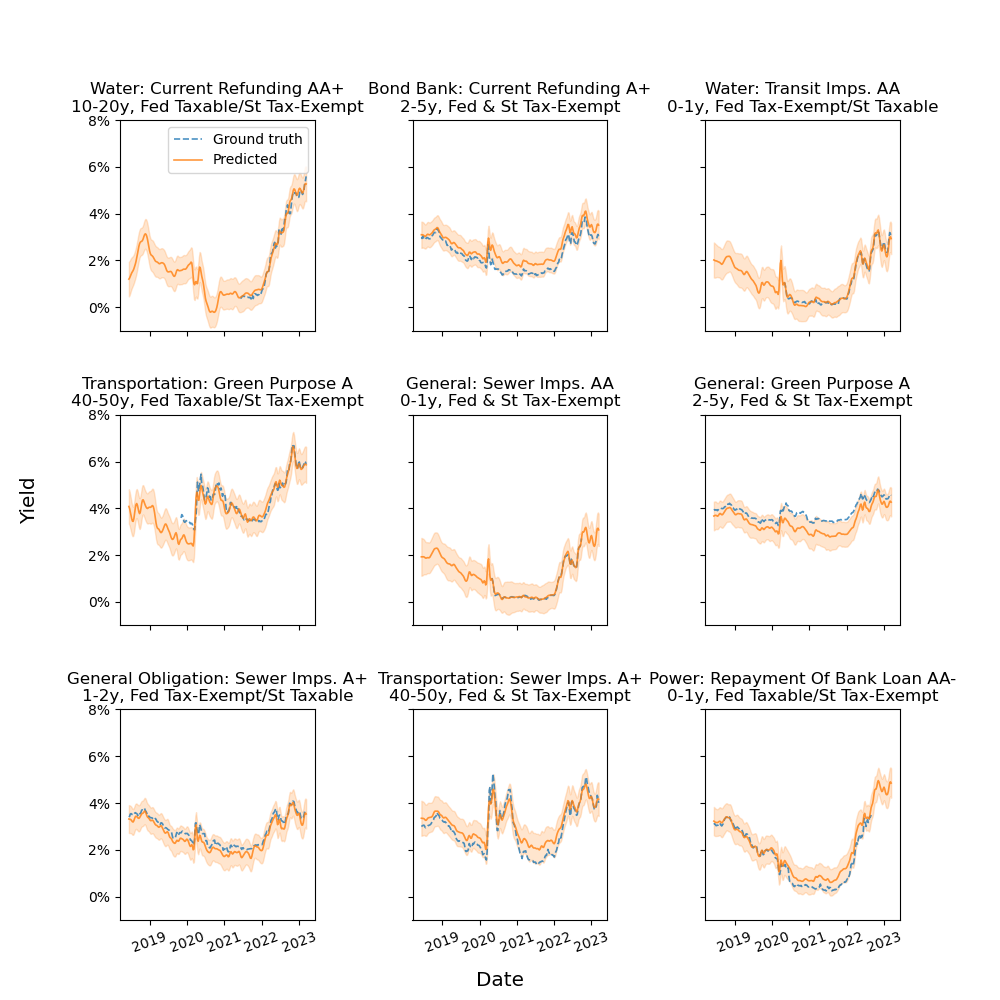

In [138]:
plot_predictions(Y_gsr, std_gsr, 'tab:orange', save=True, name='GSR')

/tmp/ipykernel_18382/3053364446.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['2018', '2019', '2020', '2021', '2022', '2023'], rotation=20)


PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `yield_predictions_KGR.pdf'.


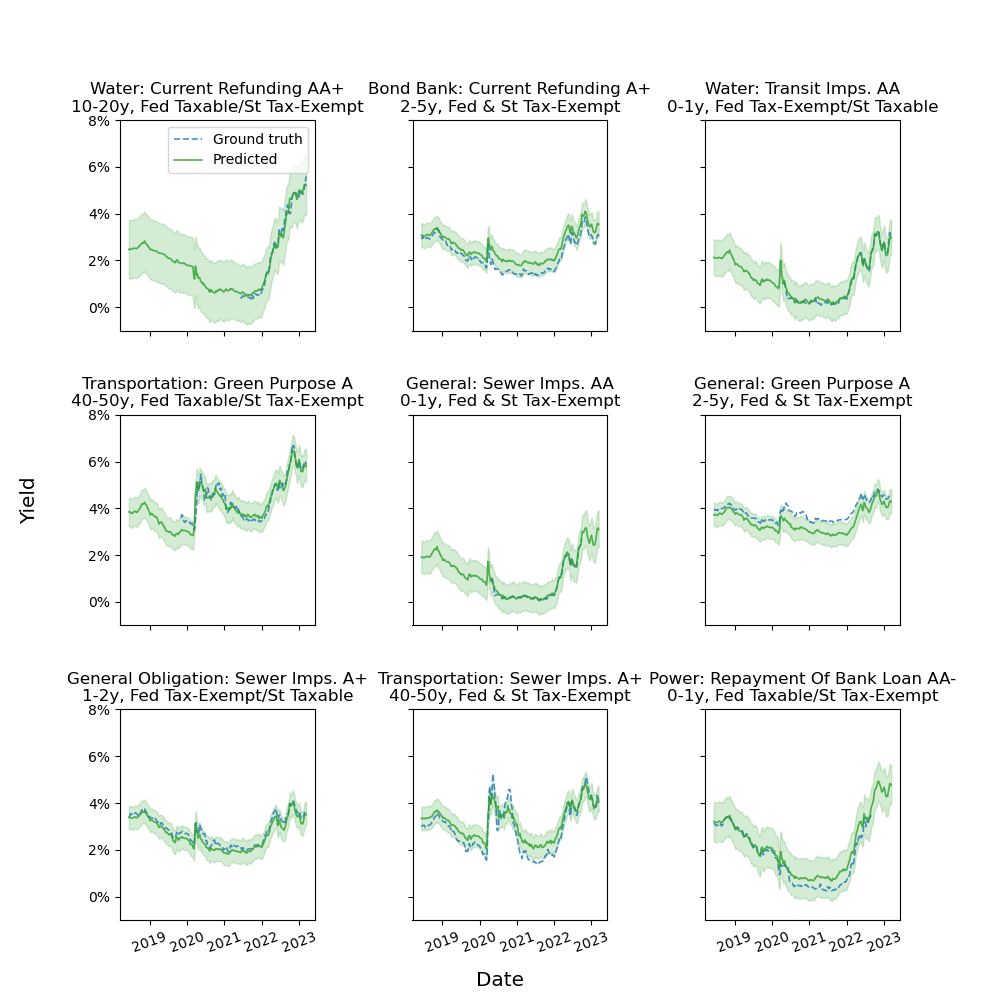

In [139]:
plot_predictions(Y_kgr, std_kgr, 'tab:green', save=True, name='KGR')

In [52]:
def get_Xy_OLS(inds):

    Is = [np.eye(N) for N in Y.shape[1:]]

    X_ols = []
    y_ols = []

    for row in inds:

        t, n, r, m, tx = row

        X_ols.append(np.concatenate([X[t, :]] + [Is[i][k] for i, k in enumerate([n, r, m, tx])]))

        y_ols.append(Y[t, n, r, m, tx])

    return np.concatenate([np.ones((len(y_ols), 1)), np.array(X_ols)], axis=1), np.array(y_ols)

In [53]:
X_ols_train, y_ols_train = get_Xy_OLS(inds_train_bondwise)
X_ols_val, y_ols_val = get_Xy_OLS(inds_val_bondwise)
X_ols_test, y_ols_test = get_Xy_OLS(inds_test_bondwise)

In [54]:
from sklearn.linear_model import Ridge, Lasso

In [55]:
ridge = Ridge(alpha=1e3)
lasso = Lasso(alpha=5e-3)

ridge.fit(X_ols_train, y_ols_train)
lasso.fit(X_ols_train, y_ols_train)

Lasso(alpha=0.005)

In [56]:
y_lasso_val = lasso.predict(X_ols_val)
y_lasso_test = lasso.predict(X_ols_test)


def mse_ols(y_pred, y_true):
    return ((y_pred - y_true) ** 2).sum() / len(y_pred)

def r_squared_ols(y_pred, y_true):
    return 1 - ((y_pred - y_true) ** 2).sum() / ((y_true.mean() - y_true) ** 2).sum() 



In [57]:

y_ridge_train = ridge.predict(X_ols_train)
y_ridge_val = ridge.predict(X_ols_val)
y_ridge_test = ridge.predict(X_ols_test)

mse_train = mse_ols(y_ridge_train, y_ols_train)
rs_train = r_squared_ols(y_ridge_train, y_ols_train)
mse_val = mse_ols(y_ridge_val, y_ols_val)
rs_val = r_squared_ols(y_ridge_val, y_ols_val)
mse_test = mse_ols(y_ridge_test, y_ols_test)
rs_test = r_squared_ols(y_ridge_test, y_ols_test)

print(f'Ridge: train: MSE: {mse_train:.3f}, R^2: {rs_train:.3f}. val: MSE: {mse_val:.3f}, R^2: {rs_val:.3f}. test: MSE: {mse_test:.3f}, R^2: {rs_test:.3f}')

Ridge: train: MSE: 0.387, R^2: 0.775. val: MSE: 0.501, R^2: 0.729. test: MSE: 0.497, R^2: 0.725


In [58]:

y_lasso_train = lasso.predict(X_ols_train)
y_lasso_val = lasso.predict(X_ols_val)
y_lasso_test = lasso.predict(X_ols_test)

mse_train = mse_ols(y_lasso_train, y_ols_train)
rs_train = r_squared_ols(y_lasso_train, y_ols_train)
mse_val = mse_ols(y_lasso_val, y_ols_val)
rs_val = r_squared_ols(y_lasso_val, y_ols_val)
mse_test = mse_ols(y_lasso_test, y_ols_test)
rs_test = r_squared_ols(y_lasso_test, y_ols_test)

print(f'Lasso: train: MSE: {mse_train:.3f}, R^2: {rs_train:.3f}. val: MSE: {mse_val:.3f}, R^2: {rs_val:.3f}. test: MSE: {mse_test:.3f}, R^2: {rs_test:.3f}')

Lasso: train: MSE: 0.424, R^2: 0.753. val: MSE: 0.482, R^2: 0.739. test: MSE: 0.506, R^2: 0.720


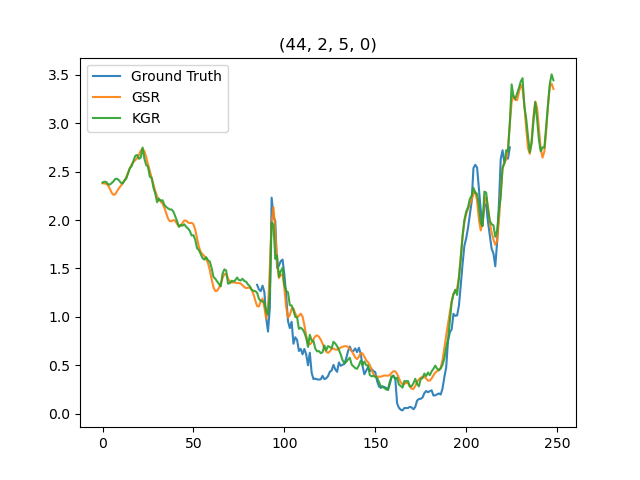

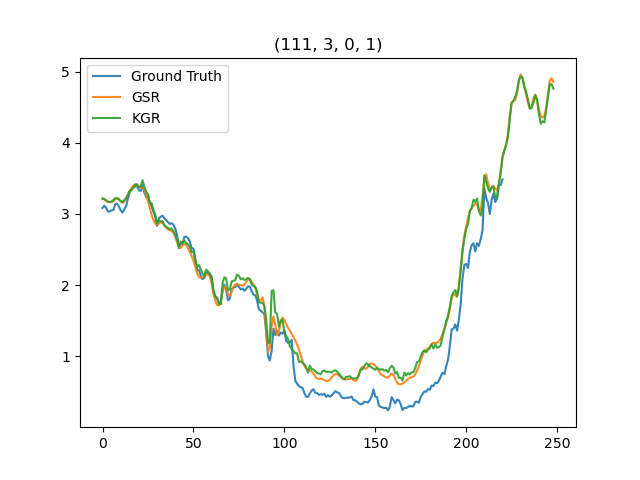

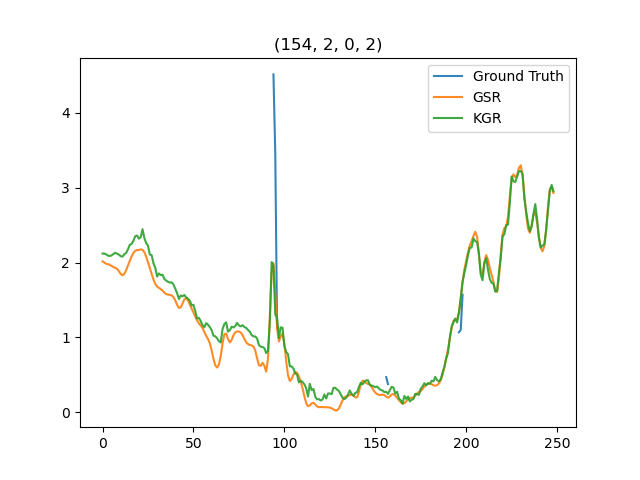

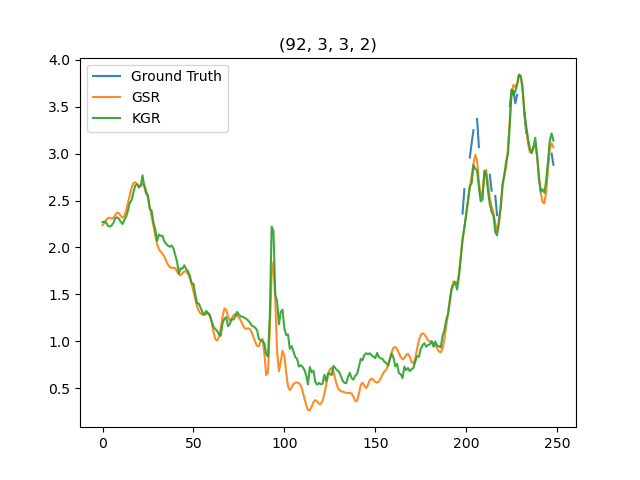

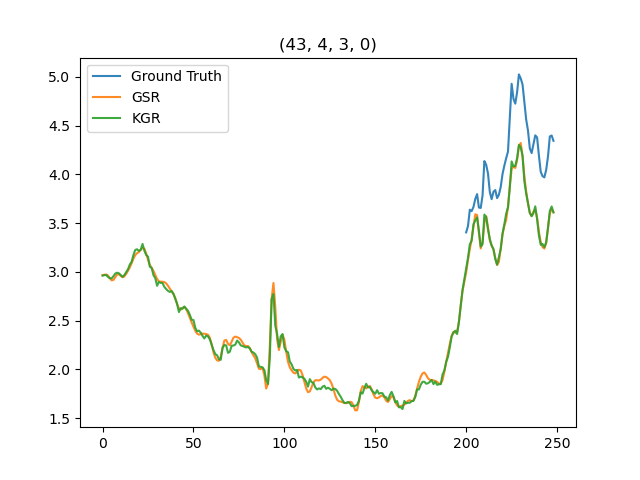

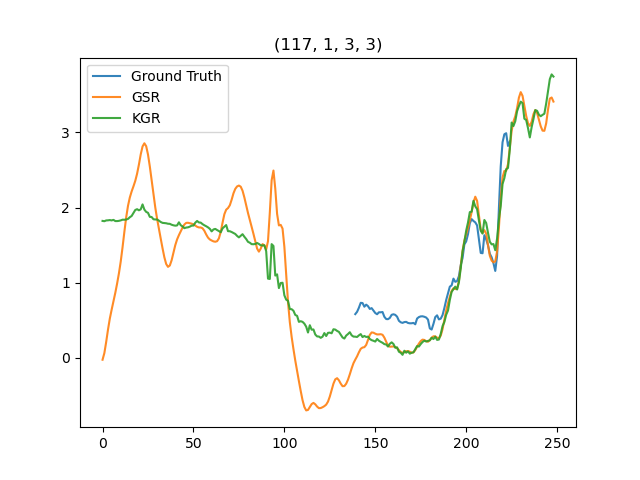

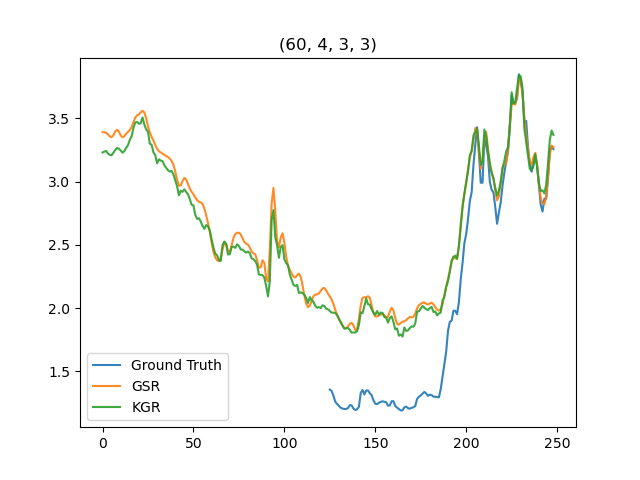

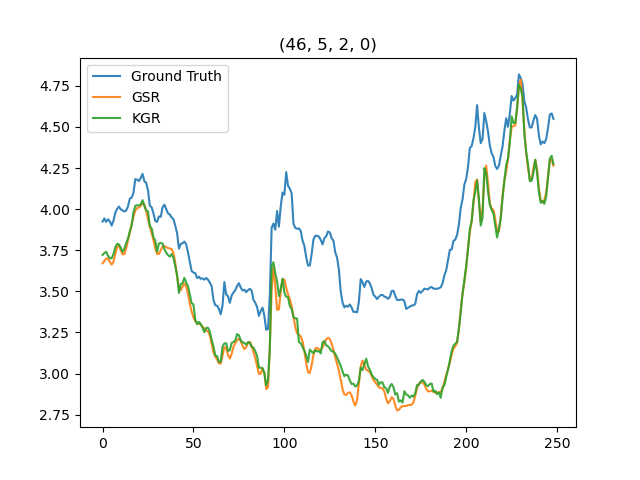

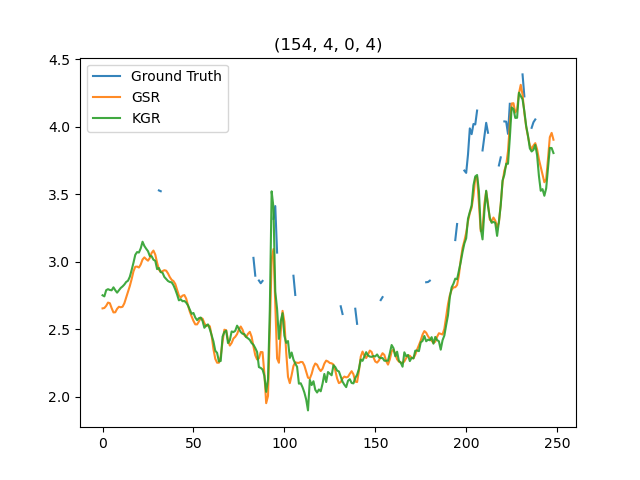

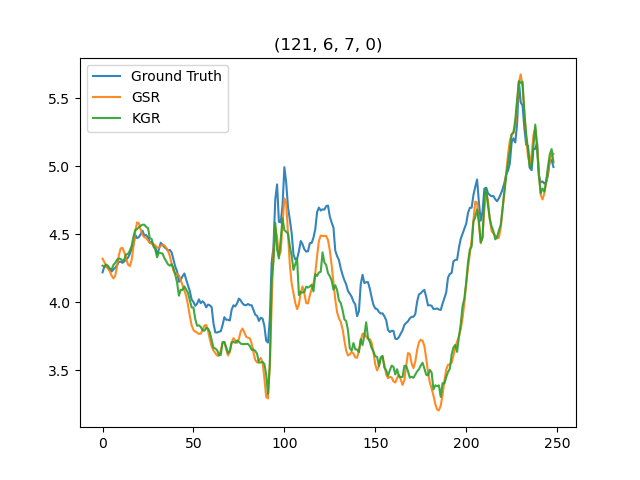

In [59]:
plt.close('all')

removed_inds = list(set([tuple(arr[1:]) for arr in inds_val_bondwise])) + list(set([tuple(arr[1:]) for arr in inds_test_bondwise]))

for ind in list(removed_inds)[30:40]:

    plt.figure()

    plt.plot(Y[:, ind[0], ind[1], ind[2], ind[3]], alpha=0.9, label='Ground Truth')
    plt.plot(Y_gsr[:, ind[0], ind[1], ind[2], ind[3]], alpha=0.9, label='GSR')
    plt.plot(Y_kgr[:, ind[0], ind[1], ind[2], ind[3]], alpha=0.9, label='KGR')

    plt.title(ind)

    plt.legend()

In [ ]:
removed_inds